# Library Imports

In [1]:
! pip install split-folders

In [2]:
! pip install patchify

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw
from patchify import patchify
import json
import os
import glob
import shutil
import splitfolders

from functools import partial
from multiprocessing.pool import Pool
from os import cpu_count, path, makedirs, listdir

import cv2
from cv2 import fillPoly
from shapely import wkt

from shapely.geometry import mapping
from tqdm import tqdm
import random

# Creating Masks

In [ ]:
def generate_localization_polygon(json_path, out_dir, color=255):
  '''
  using the coordinates from metadata available generate polygons on the images, color=255 for rgb and color=1 for grayscale images
  '''
  os.makedirs(out_dir, exist_ok=True)
  with open(json_path, "r") as f:
      annotations = json.load(f)
  h = annotations["metadata"]["height"]
  w = annotations["metadata"]["width"]
  mask_img = np.zeros((h, w), np.uint8)
  out_filename = os.path.splitext(os.path.basename(json_path))[0] + ".png"
  for feat in annotations['features']['xy']:
      feat_shape = wkt.loads(feat['wkt'])
      coords = list(mapping(feat_shape)['coordinates'][0])
      fillPoly(mask_img, [np.array(coords, np.int32)], (color))
  cv2.imwrite(os.path.join(out_dir, out_filename), mask_img)

In [ ]:
def generate_damage_polygon(json_path, out_dir):
  '''
  using coordinates from the metadata to generate polygons with different damage levels
  '''
  os.makedirs(out_dir, exist_ok=True)
  with open(json_path, "r") as f:
      annotations = json.load(f)

  h = annotations["metadata"]["height"]
  w = annotations["metadata"]["width"]
  mask_img = np.zeros((h, w), np.uint8)

  damage_dict = {
      "no-damage": 1,
      "minor-damage": 2,
      "major-damage": 3,
      "destroyed": 4,
      "un-classified": 1
  }
  out_filename = os.path.splitext(os.path.basename(json_path))[0] + ".png"
  for feat in annotations['features']['xy']:
      feat_shape = wkt.loads(feat['wkt'])
      coords = list(mapping(feat_shape)['coordinates'][0])
      fillPoly(mask_img, [np.array(coords, np.int32)], damage_dict[feat['properties']['subtype']])
  cv2.imwrite(os.path.join(out_dir, out_filename), mask_img)

In [ ]:
train_dirs =  ["/content/drive/MyDrive/capstone/data/train"]
# creating masks for the training images from the metadata available
for train_dir in train_dirs:
        out_dir = os.path.join(train_dir, "masks")
        in_dir = os.path.join(train_dir, "labels")
        pre_images = [os.path.join(in_dir, f) for f in os.listdir(in_dir) if '_pre_' in f]
        post_images = [os.path.join(in_dir, f) for f in os.listdir(in_dir) if '_post_' in f]

        pool = Pool(cpu_count())
        with tqdm(total=len(pre_images), desc='gen_pre_mask in {}'.format(train_dir)) as pbar:
            for i, v in enumerate(pool.imap_unordered(partial(generate_localization_polygon, out_dir=out_dir), pre_images)):
                pbar.update()
        with tqdm(total=len(post_images), desc='gen_post_mask in {}'.format(train_dir)) as pbar:
            for i, v in enumerate(pool.imap_unordered(partial(generate_damage_polygon, out_dir=out_dir), post_images)):
                pbar.update()

gen_pre_mask in /content/drive/MyDrive/capstone/data/train: 100%|██████████| 2799/2799 [02:06<00:00, 22.08it/s]
gen_post_mask in /content/drive/MyDrive/capstone/data/train: 100%|██████████| 2799/2799 [00:47<00:00, 59.29it/s]


In [ ]:
# looking at the images with the polygons drawn
def show_polygons(img_path, json_path):
    with open(json_path, 'r', encoding='utf-8') as image_json_file:
        image_json = json.load(image_json_file)
    coords = image_json['features']['xy']

    polygons = []

    if(len(coords) != 0):
        for coord in coords:
            if 'subtype' in coord['properties']:
                damage = coord['properties']['subtype']
            else:
                damage = 'no-damage'
            polygons.append((damage, wkt.loads(coord['wkt'])))


    img = Image.open(img_path)
    draw = ImageDraw.Draw(img, 'RGBA')

    damage_dict = {
    "no-damage": (0, 255, 0, 125), # green
    "minor-damage": (255, 255, 0, 125), # yellow
    "major-damage": (255, 128, 0, 125), # orange
    "destroyed": (255, 0, 0, 125), #red
    "un-classified": (0, 255, 0, 125) # green 
    }

    for damage, polygon in polygons:
        x,y = polygon.exterior.coords.xy
        coords = list(zip(x,y))
        draw.polygon(coords, damage_dict[damage])

    del draw
    return img


/content/drive/MyDrive/capstone/data/train/images/socal-fire_00000598_post_disaster.png 
 /content/drive/MyDrive/capstone/data/train/labels/socal-fire_00000598_post_disaster.json


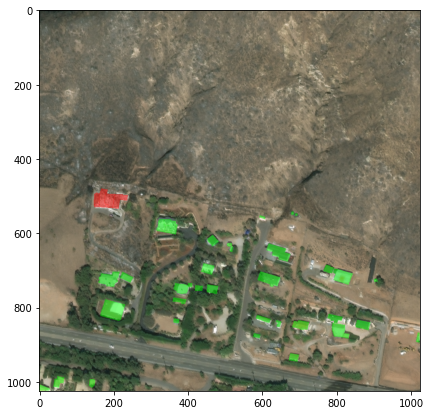

In [ ]:
# show images with polygons
all_files = []
for train in train_dirs:
    for f in os.listdir(os.path.join(train, 'images')):
        all_files.append(os.path.join(train, 'images', f))

img_path = all_files[1]
json_path = img_path.replace('/images/', '/labels/').replace('.png', '.json')

print(img_path, "\n", json_path)
  
try:
    mixed = show_polygons(img_path, json_path)
    plt.figure(figsize=(10,7))
    plt.imshow(mixed)
except Exception as e:
    print(e)

# Splitting the data into small patches

In [ ]:
def start_points(size, split_size, overlap=0):
    points = [0]
    stride = int(split_size * (1-overlap))
    counter = 1
    while True:
        pt = stride * counter
        if pt + split_size >= size:
            points.append(size - split_size)
            break
        else:
            points.append(pt)
        counter += 1
    return points

def split_image_for_train(img_path, out_dir, overlap=0):
    out_image_dir = path.join(out_dir, 'images')
    os.makedirs(out_image_dir, exist_ok=True)
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img_h, img_w, _= img.shape

    out_mask_dir = path.join(out_dir, 'masks')
    os.makedirs(out_mask_dir, exist_ok=True)
    mask_path = img_path.replace('images', 'masks')
    msk = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    msk_h, msk_w = msk.shape
    
    img_name = img_path.split('/')[-1]
    msk_name = mask_path.split('/')[-1]

    split_width = 256
    split_height = 256

    X_points = start_points(img_w, split_width, overlap=overlap)
    Y_points = start_points(img_h, split_height, overlap=overlap)

    count = 0

    for i in Y_points:
        for j in X_points:
            split_img = img[i:i+split_height, j:j+split_width]
            # print(os.path.join(out_dir, img_name.replace('.png', '_split_{}.png'.format(count))))
            cv2.imwrite(os.path.join(out_image_dir, img_name.replace('.png', '_split_{}.png'.format(count))), split_img, [cv2.IMWRITE_PNG_COMPRESSION, 9])

            split_msk = msk[i:i+split_height, j:j+split_width]
            cv2.imwrite(os.path.join(out_mask_dir, msk_name.replace('.png', '_split_{}.png'.format(count))), split_msk, [cv2.IMWRITE_PNG_COMPRESSION, 9])

            count += 1  


In [ ]:
out_dir = '/content/drive/MyDrive/capstone/data/split_data'
# creating patches for images and masks
all_files = []
for train in train_dirs:
    for f in listdir(path.join(train, 'images')):
        all_files.append(path.join(train, 'images', f))

for img_path in tqdm(all_files, desc='split_images'):
    split_image_for_train(img_path=img_path, out_dir=out_dir)

split_images: 100%|██████████| 5598/5598 [3:55:17<00:00,  2.52s/it]


In [5]:
# taking a look at the patches made
train_img_dir = '/content/drive/MyDrive/capstone/data/split_data/images'
train_mask_dir = '/content/drive/MyDrive/capstone/data/split_data/masks'

In [7]:
img_list = os.listdir(train_img_dir)

In [10]:
mask_list = os.listdir(train_mask_dir)

In [ ]:
len(img_list), len(mask_list)

(89568, 89568)

In [ ]:
img_list[0]

'hurricane-florence_00000426_post_disaster_split_8.png'

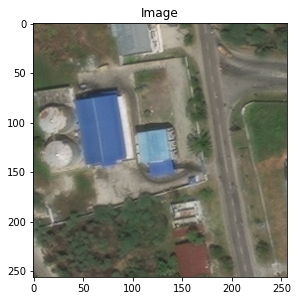

In [ ]:
num_images = len(img_list)
img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir + '/' + img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

# viewing an image patch
plt.figure(figsize=(10,7))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image');


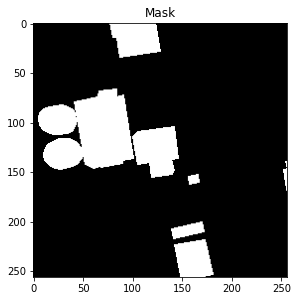

In [ ]:
# viewing a mask patch
mask_for_plot = cv2.imread(train_mask_dir + '/' + mask_list[img_num], 0)

plt.figure(figsize=(10,7))
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask');